In [1]:

# Data handling
import pandas as pd
import numpy as np
# import fairmetrics

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
import matplotlib.pyplot as plt

# EDA (pandas-profiling, etc. )
...

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


from sklearn.metrics import classification_report#, accuracy

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
...

# Other packages
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_school = pd.read_csv('../dataset/dataset.csv')

In [3]:
df_school['Target'].unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [4]:
df_school['Target'] = np.where(df_school['Target'] == 'Dropout', 'YES', 'NO')
# Convert 'Dropout_Flag' to numeric values: 1 for 'YES', 0 for 'NO'
df_school['Target'] = df_school['Target'].apply(lambda x: 1 if x == 'YES' else 0)

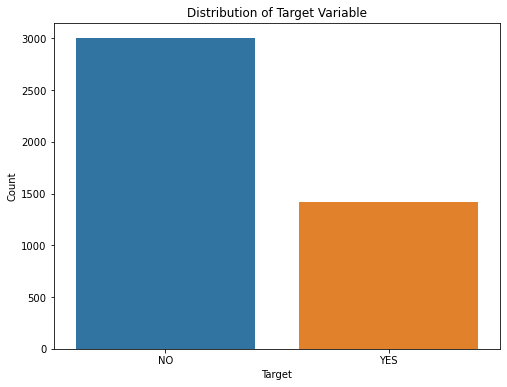

In [5]:
target_counts = df_school['Target'].value_counts()

# Create a bar plot for visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['NO', 'YES'])  # Ensure that x-ticks correspond to 'NO' and 'YES'
plt.show()

In [6]:
df_school['Target'].dtype

dtype('int64')

In [7]:
# Identify the numeric columns common to both 'test' and 'df_school' DataFrames
numeric_columns = list(set(df_school.select_dtypes(include='number').columns))

# Identify the categorical columns common to both 'test' and 'df_school' DataFrames
categorical_columns = list(set(df_school.select_dtypes(exclude='number').columns))

# Display the count and the list of numeric and categorical columns
print(f"There are {len(numeric_columns)} numeric columns: {numeric_columns}")
print(f"There are {len(categorical_columns)} categorical columns: {categorical_columns}")


There are 35 numeric columns: ['Unemployment rate', "Father's qualification", 'Curricular units 1st sem (evaluations)', 'Curricular units 2nd sem (without evaluations)', 'Target', "Father's occupation", "Mother's occupation", "Mother's qualification", 'Daytime/evening attendance', 'Application mode', 'Application order', 'Gender', 'Curricular units 1st sem (without evaluations)', 'Inflation rate', 'Displaced', 'International', 'Marital status', 'Scholarship holder', 'Debtor', 'Age at enrollment', 'Curricular units 2nd sem (credited)', 'GDP', 'Curricular units 2nd sem (grade)', 'Course', 'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)', 'Previous qualification', 'Curricular units 1st sem (credited)', 'Curricular units 2nd sem (evaluations)', 'Educational special needs', 'Nacionality', 'Curricular units 1st sem (enrolled)', 'Tuition fees up to date', 'Curricular units 2nd sem (enrolled)', 'Curricular units 1st sem (grade)']
There are 0 categorical columns: []


# Model 1: Fairness through awareness

In [8]:
y=df_school['Target']
X=df_school.iloc[:,:-1]

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

#### Training the Model with Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


In [11]:
# spliting the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

import warnings
from sklearn.exceptions import ConvergenceWarning

# create the model
log_reg = LogisticRegression()

# fit the model on the training data
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    log_reg.fit(X=X_train, y=y_train)

# make predictions on the testing data
y_pred = log_reg.predict(X_test)

# calculate cross-entropy loss
cel = log_loss(y_test, y_pred)

print("Cross-Entropy Loss:", cel)


Cross-Entropy Loss: 4.253959111138861


In [12]:
print("Accuracy Score: ",accuracy_score(y_test,y_pred))
print("Precision Score: ", precision_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


Accuracy Score:  0.8768361581920904
Precision Score:  0.8540772532188842
Recall Score:  0.7262773722627737
F1 Score:  0.7850098619329388


In [13]:
def plot_confusions(ytest, ypred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

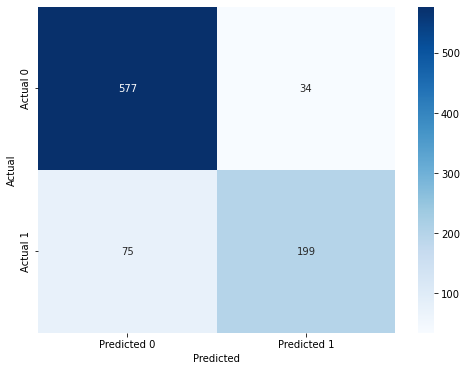

In [14]:
plot_confusions(y_test,y_pred)

## PERFORMANCE ACROSS GROUPS FOR FAIRNESS

In [15]:
fairX = X_test.copy()
fairX['ytest'] = y_test
fairX['predictions'] = y_pred

In [16]:
female_df= fairX[fairX.Gender==0]
male_df= fairX[fairX.Gender==1]

In [17]:
print("Accuracy Score for females: ",accuracy_score(female_df.ytest, female_df.predictions))
print("Precision Score for females: ", precision_score(female_df.ytest, female_df.predictions))
print("Recall Score for females: ", recall_score(female_df.ytest, female_df.predictions))
print("F1 Score for females: ", f1_score(female_df.ytest, female_df.predictions))

Accuracy Score for females:  0.9
Precision Score for females:  0.8620689655172413
Recall Score for females:  0.6944444444444444
F1 Score for females:  0.7692307692307692


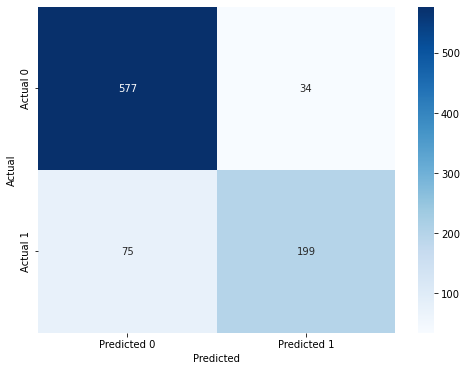

In [18]:
plot_confusions(female_df.ytest, female_df.predictions)

In [19]:
print("Accuracy Score for males: ",accuracy_score(male_df.ytest, male_df.predictions))
print("Precision Score for males: ", precision_score(male_df.ytest, male_df.predictions))
print("Recall Score for males: ", recall_score(male_df.ytest, male_df.predictions))
print("F1 Score for males: ", f1_score(male_df.ytest, male_df.predictions))

Accuracy Score for males:  0.8280701754385965
Precision Score for males:  0.8461538461538461
Recall Score for males:  0.7615384615384615
F1 Score for males:  0.8016194331983805


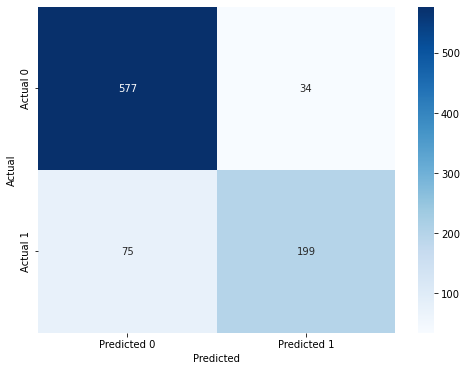

In [20]:
plot_confusions(male_df.ytest, male_df.predictions)


In [21]:
# mask = X_test.Gender
# fairmetrics.get_statistics(log_reg, X_test, y_test.values, y_pred, mask.values, confusion=True)

In [22]:
# Model 2: Fairness

                                           Feature  Importance
14                         Tuition fees up to date           1
16                              Scholarship holder           2
18                                   International           3
28             Curricular units 2nd sem (approved)           4
26             Curricular units 2nd sem (enrolled)           5
13                                          Debtor           6
25             Curricular units 2nd sem (credited)           7
15                                          Gender           8
22             Curricular units 1st sem (approved)           9
24  Curricular units 1st sem (without evaluations)          10
0                                   Marital status          11
11                                       Displaced          12
3                                           Course          13
31                               Unemployment rate          14
30  Curricular units 2nd sem (without evaluations)     

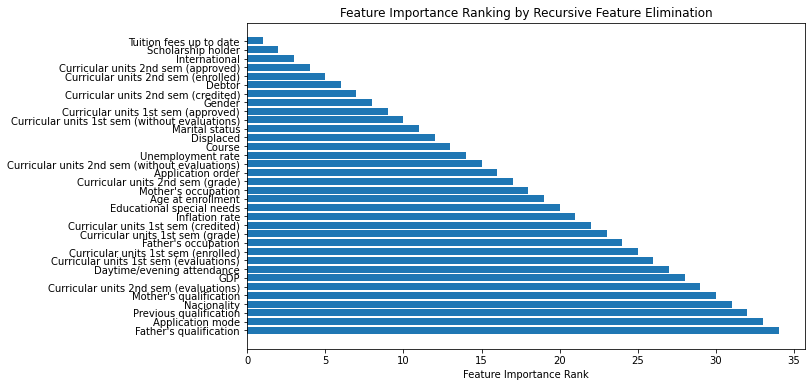

In [23]:
from sklearn.feature_selection import RFE

# Create the RFE object and rank each feature
rfe = RFE(estimator=log_reg, n_features_to_select=1)
rfe = rfe.fit(X_train, y_train)

# Rank features by importance
ranking = rfe.ranking_
ranked_features = pd.DataFrame({'Feature': X.columns, 'Importance': ranking})
print(ranked_features.sort_values('Importance'))

# Sort the DataFrame by importance
ranked_features_sorted = ranked_features.sort_values('Importance')


plt.figure(figsize=(10, 6))
plt.barh(ranked_features_sorted['Feature'], ranked_features_sorted['Importance'])
plt.xlabel('Feature Importance Rank')
plt.title('Feature Importance Ranking by Recursive Feature Elimination')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()